<a href="https://colab.research.google.com/github/thedavidemmanuel/BTC-Time-Series-Forecasting/blob/main/btc_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from google.colab import drive
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [55]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
# %%
# Define file paths
bitstamp_path = '/content/drive/MyDrive/BTC Model/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv'
coinbase_path = '/content/drive/MyDrive/BTC Model/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv'

In [78]:
# Load the data
def load_data(file_path):
    print(f"Loading data from: {file_path}")
    data = pd.read_csv(file_path, on_bad_lines='skip', low_memory=False)
    print(f"Data loaded successfully. Shape: {data.shape}")
    return data

bitstamp_data = load_data(bitstamp_path)
coinbase_data = load_data(coinbase_path)

Loading data from: /content/drive/MyDrive/BTC Model/bitstampUSD_1-min_data_2012-01-01_to_2020-04-22.csv
Data loaded successfully. Shape: (4363457, 8)
Loading data from: /content/drive/MyDrive/BTC Model/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv
Data loaded successfully. Shape: (2099760, 8)


In [79]:
# Preprocess data
def preprocess_data(data):
    print("Preprocessing data...")
    # Convert 'Volume_(BTC)' to numeric
    data['Volume_(BTC)'] = pd.to_numeric(data['Volume_(BTC)'], errors='coerce')
    # Forward fill missing values
    data = data.ffill()
    # Drop any remaining NaNs
    data = data.dropna()
    print(f"Preprocessing complete. New shape: {data.shape}")
    return data

bitstamp_data = preprocess_data(bitstamp_data)
coinbase_data = preprocess_data(coinbase_data)

# Set 'Timestamp' as index
def set_timestamp_index(data):
    print("Setting timestamp as index...")
    data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')
    data = data.set_index('Timestamp')
    print("Timestamp set as index.")
    return data

bitstamp_data = set_timestamp_index(bitstamp_data)
coinbase_data = set_timestamp_index(coinbase_data)

# Resample to hourly data
def resample_hourly(data):
    print("Resampling to hourly data...")
    data_hourly = data.resample('H').mean()
    data_hourly = data_hourly.ffill()
    print(f"Resampling complete. New shape: {data_hourly.shape}")
    return data_hourly

bitstamp_data_hourly = resample_hourly(bitstamp_data)
coinbase_data_hourly = resample_hourly(coinbase_data)


Preprocessing data...
Preprocessing complete. New shape: (4363457, 8)
Preprocessing data...
Preprocessing complete. New shape: (2099760, 8)
Setting timestamp as index...
Timestamp set as index.
Setting timestamp as index...
Timestamp set as index.
Resampling to hourly data...
Resampling complete. New shape: (72834, 7)
Resampling to hourly data...
Resampling complete. New shape: (35970, 7)


In [80]:
# Combine the datasets
print("Combining datasets...")
combined_data = pd.concat(
    [bitstamp_data_hourly['Close'], coinbase_data_hourly['Close']],
    axis=1,
    join='inner'
)
combined_data.columns = ['Bitstamp_Close', 'Coinbase_Close']
combined_data['Average_Close'] = combined_data.mean(axis=1)
print(f"Datasets combined. Shape: {combined_data.shape}")

# Feature Engineering: Adding Technical Indicators
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def add_technical_indicators(df):
    print("Adding technical indicators...")
    df['EMA_10'] = df['Average_Close'].ewm(span=10, adjust=False).mean()
    df['EMA_50'] = df['Average_Close'].ewm(span=50, adjust=False).mean()
    df['RSI'] = compute_rsi(df['Average_Close'], window=14)
    df['MACD'] = df['EMA_10'] - df['EMA_50']
    # Fill NaN values resulting from indicator calculations
    df = df.fillna(method='bfill').fillna(method='ffill')
    print("Technical indicators added.")
    return df

combined_data = add_technical_indicators(combined_data)

# Display the first few rows of the combined data with indicators
print("\nCombined Data Head:")
print(combined_data.head())


Combining datasets...
Datasets combined. Shape: (35970, 3)
Adding technical indicators...
Technical indicators added.

Combined Data Head:
                     Bitstamp_Close  Coinbase_Close  Average_Close  \
Timestamp                                                            
2014-12-01 05:00:00      378.437167           300.0     339.218583   
2014-12-01 06:00:00      380.137333           342.0     361.068667   
2014-12-01 07:00:00      380.184667           370.0     375.092333   
2014-12-01 08:00:00      377.959000           370.0     373.979500   
2014-12-01 09:00:00      377.931333           370.0     373.965667   

                         EMA_10      EMA_50        RSI       MACD  
Timestamp                                                          
2014-12-01 05:00:00  339.218583  339.218583  93.975306   0.000000  
2014-12-01 06:00:00  343.191326  340.075449  93.975306   3.115876  
2014-12-01 07:00:00  348.991509  341.448660  93.975306   7.542848  
2014-12-01 08:00:00  353.53478

<ipython-input-80-607ae62e86e4>:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')


In [81]:
# Scale the data properly to avoid data leakage
print("Scaling the data...")

# Split the data into training and testing sets before scaling
train_size = int(len(combined_data) * 0.8)
train_data_raw = combined_data[:train_size]
test_data_raw = combined_data[train_size:]

# Define features for scaling
features = ['Average_Close', 'EMA_10', 'EMA_50', 'RSI', 'MACD']

# Initialize scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit scaler on training data and transform both training and testing data
scaled_train = scaler.fit_transform(train_data_raw[features])
scaled_test = scaler.transform(test_data_raw[features])

print("Data scaling complete.")

# Display scaled data head
print("\nScaled Training Data Head:")
print(scaled_train[:5])
print("\nScaled Testing Data Head:")
print(scaled_test[:5])


Scaling the data...
Data scaling complete.

Scaled Training Data Head:
[[0.00993824 0.00923463 0.00781574 0.93975306 0.49115058]
 [0.01105503 0.00943969 0.00786165 0.93975306 0.49195949]
 [0.0117718  0.00973908 0.00793524 0.93975306 0.49310878]
 [0.01171492 0.00997358 0.00800361 0.93975306 0.49395707]
 [0.01171421 0.01016533 0.00806926 0.93975306 0.49460338]]

Scaled Testing Data Head:
[[0.45959503 0.46554554 0.48316025 0.56943615 0.48340365]
 [0.46072571 0.46535189 0.48305418 0.5312936  0.48294355]
 [0.45984987 0.46503263 0.48291625 0.45846888 0.48200599]
 [0.45812515 0.46445473 0.48271282 0.48631102 0.48008494]
 [0.45258752 0.46296511 0.48228967 0.41133118 0.47464267]]


In [82]:
# Create sequences for the model
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length][0]  # 'Average_Close' is the first feature
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

seq_length = 48  # Using 48 hours of data to predict the next hour
X_train, y_train = create_sequences(scaled_train, seq_length)
X_test, y_test = create_sequences(scaled_test, seq_length)

print(f"Sequences created. X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# Reshape input data for LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], len(features)))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], len(features)))

print(f"Reshaped X_train shape: {X_train.shape}")
print(f"Reshaped X_test shape: {X_test.shape}")


Sequences created. X_train shape: (28728, 48, 5), y_train shape: (28728,)
X_test shape: (7146, 48, 5), y_test shape: (7146,)
Reshaped X_train shape: (28728, 48, 5)
Reshaped X_test shape: (7146, 48, 5)


In [83]:
# Split training data into training and validation sets
validation_split = 0.1
val_size = int(len(X_train) * validation_split)

X_train_final = X_train[:-val_size]
y_train_final = y_train[:-val_size]
X_val = X_train[-val_size:]
y_val = y_train[-val_size:]

print(f"Final Training Data shape: {X_train_final.shape}, {y_train_final.shape}")
print(f"Validation Data shape: {X_val.shape}, {y_val.shape}")


Final Training Data shape: (25856, 48, 5), (25856,)
Validation Data shape: (2872, 48, 5), (2872,)


In [86]:
# Create tf.data.Dataset
def create_dataset_tf(X, y, batch_size=32, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

batch_size = 32
train_dataset = create_dataset_tf(X_train_final, y_train_final, batch_size=batch_size, shuffle=True)
val_dataset = create_dataset_tf(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dataset = create_dataset_tf(X_test, y_test, batch_size=batch_size, shuffle=False)

In [89]:
# Build the Bidirectional GRU model
model = Sequential([
    Bidirectional(GRU(64, return_sequences=True, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001))),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(GRU(64, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.001))),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [90]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


In [91]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=val_dataset,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
808/808 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.5655 - mae: 0.3715 - val_loss: 0.1851 - val_mae: 0.2343 - learning_rate: 0.0010
Epoch 2/100
808/808 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 0.1082 - mae: 0.0732 - val_loss: 0.0904 - val_mae: 0.1605 - learning_rate: 0.0010
Epoch 3/100
808/808 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 0.0456 - mae: 0.0387 - val_loss: 0.0657 - val_mae: 0.1737 - learning_rate: 0.0010
Epoch 4/100
808/808 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0206 - mae: 0.0301 - val_loss: 0.0334 - val_mae: 0.1241 - learning_rate: 0.0010
Epoch 5/100
808/808 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0093 - mae: 0.0267 - val_loss: 0.0306 - val_mae: 0.1218 - learning_rate: 0.0010
Epoch 6/100
808/808 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - loss: 0.0048 - mae: 0.0256 - val_loss: 0.0741 - val_mae: 0.2455 - learning_rate: 0.0010
Epoch 7/100
808/808 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.0073 - mae: 0.0284 - val_loss: 0.0528 - val_mae: 0.1845 - learnin

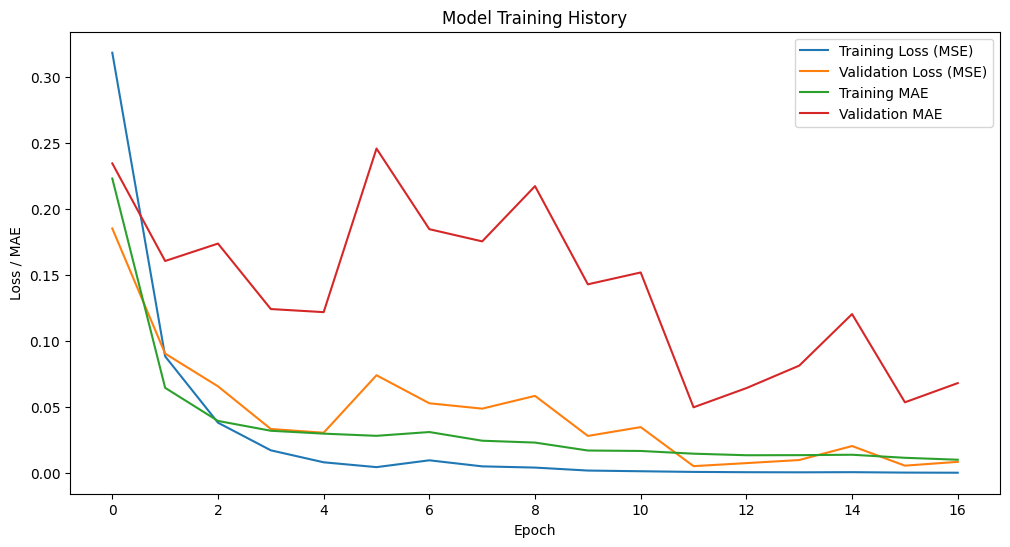

In [97]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss (MSE)')
plt.plot(history.history['val_loss'], label='Validation Loss (MSE)')
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss / MAE')
plt.legend()
plt.show()

In [98]:
# Evaluate the model on training and testing datasets
# Create a separate evaluation dataset without shuffling
train_dataset_eval = create_dataset_tf(X_train_final, y_train_final, batch_size=batch_size, shuffle=False)

train_loss, train_mae = model.evaluate(train_dataset_eval, verbose=0)
val_loss, val_mae = model.evaluate(val_dataset, verbose=0)
test_loss, test_mae = model.evaluate(test_dataset, verbose=0)

print(f'Training MSE: {train_loss:.4f}, MAE: {train_mae:.4f}')
print(f'Validation MSE: {val_loss:.4f}, MAE: {val_mae:.4f}')
print(f'Test MSE: {test_loss:.4f}, MAE: {test_mae:.4f}')

Training MSE: 0.0007, MAE: 0.0171
Validation MSE: 0.0053, MAE: 0.0498
Test MSE: 0.0019, MAE: 0.0380


In [99]:
# Make predictions
train_predict = model.predict(train_dataset_eval)
val_predict = model.predict(val_dataset)
test_predict = model.predict(test_dataset)


808/808 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
224/224 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [100]:
# Inverse transform predictions and actual values
def inverse_transform(scaled_data, scaler, feature_index=0):
    dummy = np.zeros((scaled_data.shape[0], scaler.scale_.shape[0]))
    dummy[:, feature_index] = scaled_data[:, 0]
    inversed = scaler.inverse_transform(dummy)[:, feature_index]
    return inversed

train_predict_inv = inverse_transform(train_predict, scaler)
y_train_final_inv = inverse_transform(y_train_final.reshape(-1, 1), scaler)
val_predict_inv = inverse_transform(val_predict, scaler)
y_val_inv = inverse_transform(y_val.reshape(-1, 1), scaler)
test_predict_inv = inverse_transform(test_predict, scaler)
y_test_inv = inverse_transform(y_test.reshape(-1, 1), scaler)


In [101]:
# Calculate performance metrics
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    return mse, rmse, mae, r2

# Training metrics
train_mse, train_rmse, train_mae_val, train_r2 = calculate_metrics(y_train_final_inv, train_predict_inv)
# Validation metrics
val_mse, val_rmse, val_mae_val, val_r2 = calculate_metrics(y_val_inv, val_predict_inv)
# Test metrics
test_mse, test_rmse, test_mae_val, test_r2 = calculate_metrics(y_test_inv, test_predict_inv)

print("\nTraining Data Metrics:")
print(f"MSE: {train_mse:.2f}")
print(f"RMSE: {train_rmse:.2f}")
print(f"MAE: {train_mae_val:.2f}")
print(f"R2 Score: {train_r2:.4f}")

print("\nValidation Data Metrics:")
print(f"MSE: {val_mse:.2f}")
print(f"RMSE: {val_rmse:.2f}")
print(f"MAE: {val_mae_val:.2f}")
print(f"R2 Score: {val_r2:.4f}")

print("\nTest Data Metrics:")
print(f"MSE: {test_mse:.2f}")
print(f"RMSE: {test_rmse:.2f}")
print(f"MAE: {test_mae_val:.2f}")
print(f"R2 Score: {test_r2:.4f}")



Training Data Metrics:
MSE: 156917.36
RMSE: 396.13
MAE: 335.45
R2 Score: 0.9184

Validation Data Metrics:
MSE: 1903515.93
RMSE: 1379.68
MAE: 974.32
R2 Score: 0.7911

Test Data Metrics:
MSE: 599321.02
RMSE: 774.16
MAE: 743.07
R2 Score: 0.7428


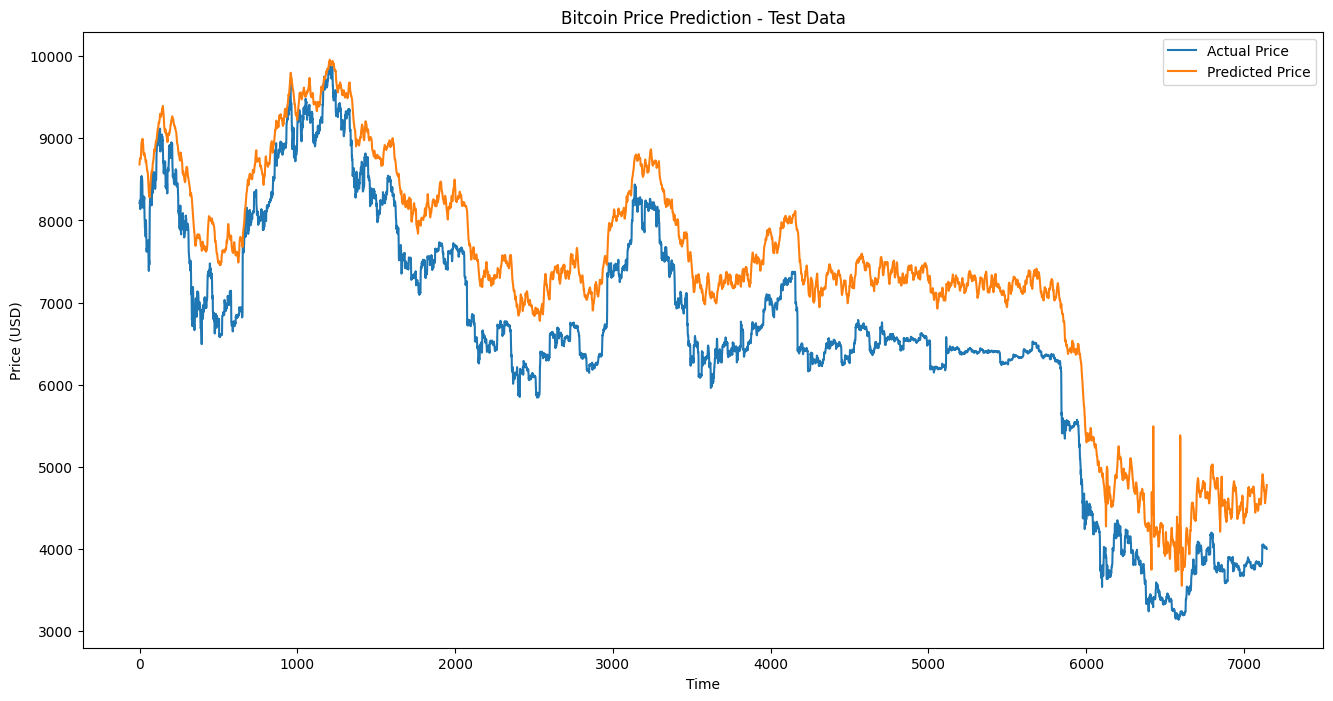

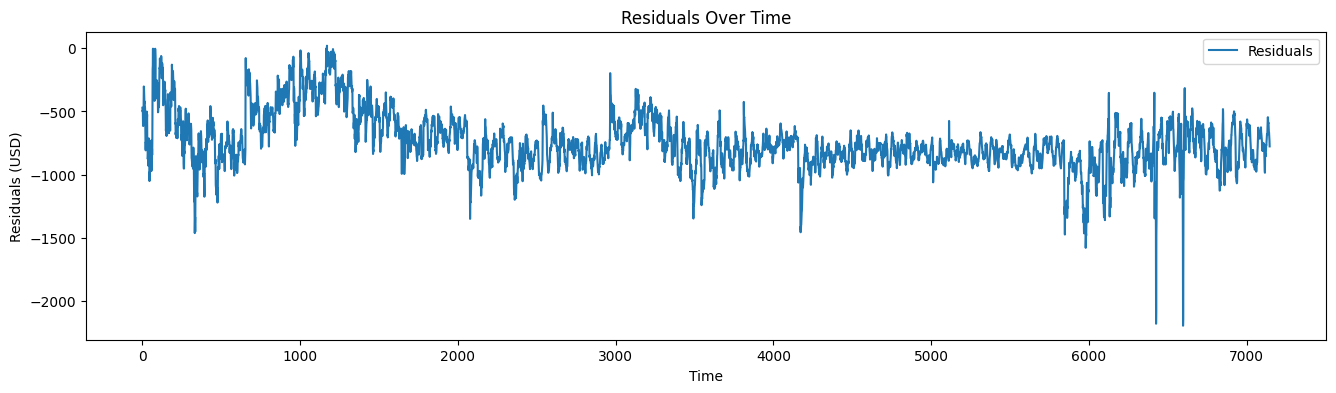

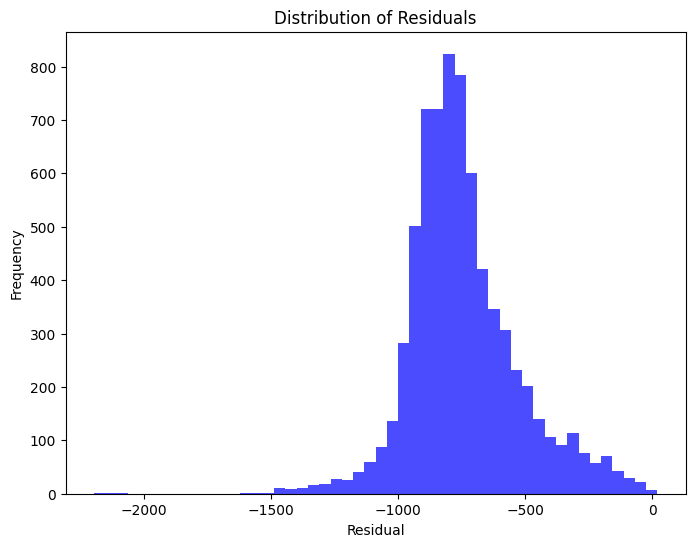

In [102]:
# Visualize predictions on test data
plt.figure(figsize=(16, 8))
plt.plot(y_test_inv, label='Actual Price')
plt.plot(test_predict_inv, label='Predicted Price')
plt.title('Bitcoin Price Prediction - Test Data')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

# Plot residuals
residuals = y_test_inv - test_predict_inv
plt.figure(figsize=(16, 4))
plt.plot(residuals, label='Residuals')
plt.title('Residuals Over Time')
plt.xlabel('Time')
plt.ylabel('Residuals (USD)')
plt.legend()
plt.show()

# Plot distribution of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Residuals')
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.show()